In [2]:
import math
import random
from time import time
import sys
import heapq

class Worker:
    def __init__(self, worker_id, v_init, Lmax, *job_types) -> None:
        self.worker_id = worker_id
        self.v_init = v_init
        self.Lmax = Lmax
        self.job_types = set(job_types)
        self.v = v_init
        # self.jobs = []
        # 移動完了までの時間
        self.move_cnt = 0
        self.acts = [None]*1000

    def clear(self):
        self.v = self.v_init
        self.acts = [None]*1000

class Job:
    def __init__(self, job_id, job_type, Ntask, v, rewards, depends) -> None:
        self.job_id = job_id
        self.job_type = job_type
        self.Ntask = Ntask
        self.rest_task = Ntask
        self.v = v
        self.depends = depends
        self.depend_cnt = len(depends)
        self.rewards = [0]*1000
        it = iter(rewards)
        self.reward_list = list(zip(it, it))
        self.end_turn = math.inf
        pre_t, pre_y = rewards[0], rewards[1]
        it = iter(rewards[2:])
        for t, y in zip(it, it):
            t -= 1
            for i in range(pre_t, t):
                self.rewards[i] = (y-pre_y)*(i-pre_t)/(t-pre_t)+pre_y
            pre_t, pre_y = t, y
        self.max_rewards = max(self.rewards)

    def clear(self):
        self.depend_cnt = len(self.depends)
        self.end_turn = math.inf
        self.rest_task = self.Ntask

data = []
for fid in range(100):
    with open(f"../tools/in/testcase_{fid:04}_raw.txt") as f:
        Tmax = int(f.readline())
        Nv, Ne = map(int, f.readline().split())
        UVD = [list(map(int, f.readline().split())) for _ in range(Ne)]
        Nworker = int(f.readline())
        workers = []
        for worker_id in range(Nworker):
            v_init, Lmax, Njobtypes, *job_types = map(int, f.readline().split())
            v_init -= 1
            worker = Worker(worker_id, v_init, Lmax, *job_types)
            workers.append(worker)
        Njob = int(f.readline())
        jobs = []
        for job_id in range(Njob):
            _, job_type, Ntask, vjob = map(int, f.readline().split())
            vjob -= 1
            rewards = list(map(int, f.readline().split()))[1:]
            depends = list(map(lambda x: int(x)-1, f.readline().split()))[1:]
            job = Job(job_id, job_type, Ntask, vjob, rewards, depends)
            jobs.append(job)
        G = [[] for _ in range(Nv)]
        for u, v, d in UVD:
            u -= 1
            v -= 1
            G[u].append((v, d))
            G[v].append((u, d))
        dists = [[math.inf]*Nv for _ in range(Nv)]
        for start_node in range(Nv):
            q = [(0, start_node)]
            dists_ = dists[start_node]
            dists_[start_node] = 0
            appeared = [False]*Nv
            while q:
                d, u = heapq.heappop(q)
                if appeared[u]:
                    continue
                appeared[u] = True
                for v, c in G[u]:
                    d_ = d+c
                    if dists_[v] > d_:
                        dists_[v] = d_
                        heapq.heappush(q, (d_, v))
    data.append((Tmax, workers, jobs, dists))


見たいもの
- jobの生存期間
- jobのscoreの平均
- jobの必要時間対workerの総可能タスク

300


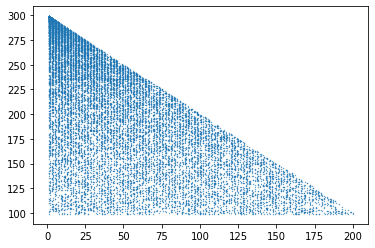

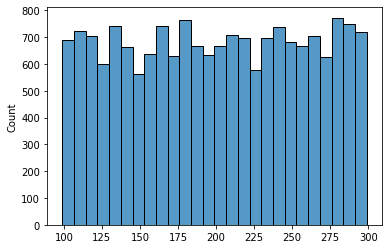

700


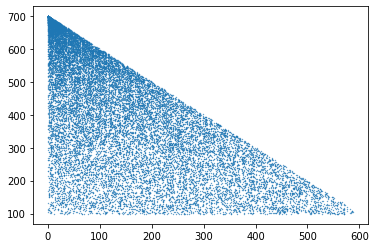

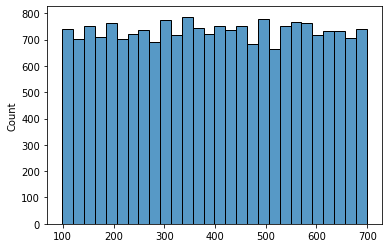

1000


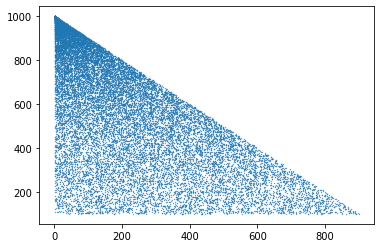

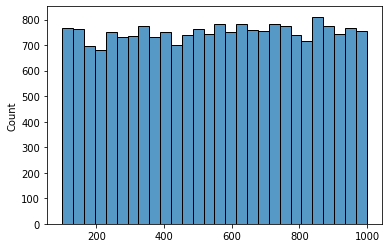

1000


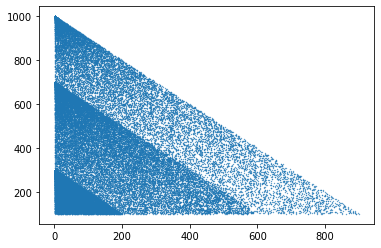

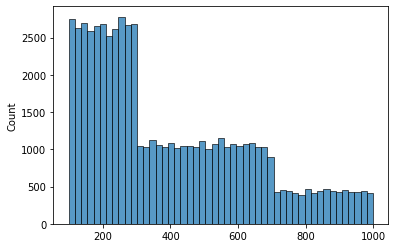

In [3]:
# jobの生存期間
import matplotlib.pylab as plt
import seaborn as sns
for t_fil in [300, 700, 1000]:
    Xs, Ys = [], []
    for Tmax, workers, jobs, dists in data:
        if Tmax!=t_fil:
            continue
        for job in jobs:
            Xs.append(job.reward_list[1][0])
            Ys.append(job.reward_list[-2][0]-job.reward_list[1][0])
    print(t_fil)
    plt.scatter(Xs, Ys, s=0.1)
    plt.show()
    sns.histplot(x=Ys)
    plt.show()
Xs, Ys = [], []
for Tmax, workers, jobs, dists in data:
    for job in jobs:
        Xs.append(job.reward_list[1][0])
        Ys.append(job.reward_list[-2][0]-job.reward_list[1][0])
print(t_fil)
plt.scatter(Xs, Ys, s=0.1)
plt.show()
sns.histplot(x=Ys)
plt.show()

300


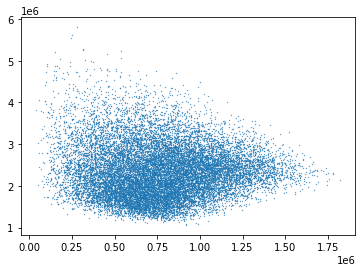

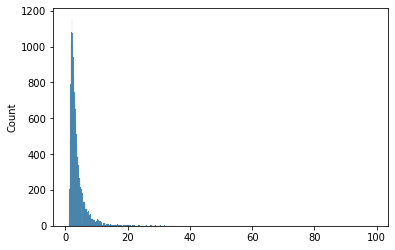

700


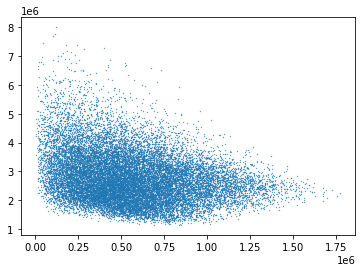

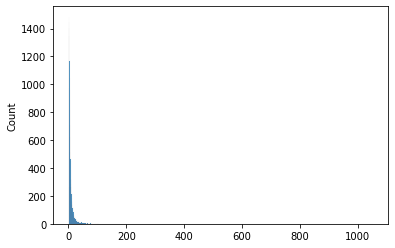

1000


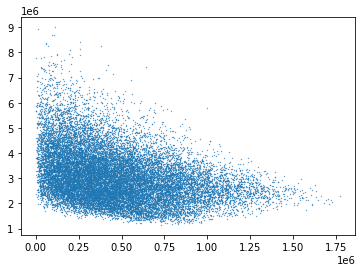

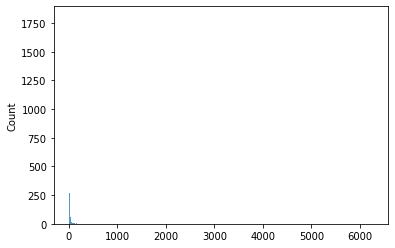

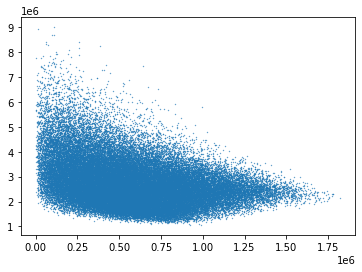

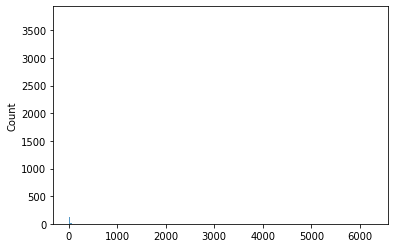

In [4]:
# jobのrewardsの分散
import matplotlib.pylab as plt
import seaborn as sns
N_phase = 4
for t_fil in [300, 700, 1000]:
    Xs, Ys, diff = [], [], []
    for Tmax, workers, jobs, dists in data:
        if Tmax!=t_fil:
            continue
        for job in jobs:
            min_r = min(map(lambda x: x[1], job.reward_list[1:-1]))
            max_r = max(map(lambda x: x[1], job.reward_list[1:-1]))
            Xs.append(min_r)
            Ys.append(max_r)
            diff.append(max_r/min_r)
    print(t_fil)
    plt.scatter(Xs, Ys, s=0.1)
    plt.show()
    sns.histplot(x=diff)
    plt.show()
Xs, Ys, diff = [], [], []
for Tmax, workers, jobs, dists in data:
    for job in jobs:
        min_r = min(map(lambda x: x[1], job.reward_list[1:-1]))
        max_r = max(map(lambda x: x[1], job.reward_list[1:-1]))
        Xs.append(min_r)
        Ys.append(max_r)
        diff.append(max_r/min_r)
plt.scatter(Xs, Ys, s=0.1)
plt.show()
sns.histplot(x=diff)
plt.show()


見たいもの
- jobの生存期間
- jobのscoreの平均
- jobの必要時間対workerの総可能タスク

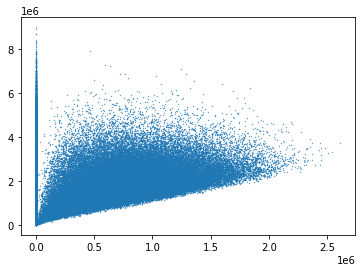

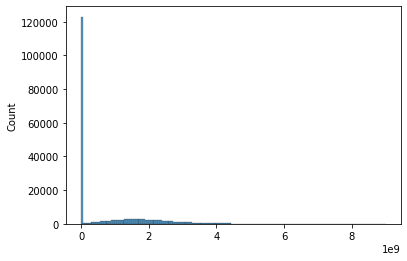

In [5]:
# jobのrewardsの分散
import matplotlib.pylab as plt
import seaborn as sns
N_phase = 4
Xs, Ys, diff = [], [], []
for Tmax, workers, jobs, dists in data:
    for job in jobs:
        phase_se = [(Tmax//N_phase*t, Tmax//N_phase*(t+1)) for t in range(N_phase)]
        phase_data = []
        for s, e in phase_se:
            min_r = min(job.rewards[s:e])+0.001
            max_r = max(job.rewards[s:e])
            Xs.append(min_r)
            Ys.append(max_r)
            diff.append(max_r/min_r)
plt.scatter(Xs, Ys, s=0.1)
plt.show()
sns.histplot(x=diff)
plt.show()


In [6]:
# jobのrewardsの分散
import matplotlib.pylab as plt
import seaborn as sns
N_phase = 4
for t_fil in [300, 700, 1000]:
    job_cnts = []
    work_cnts = []
    print(t_fil)
    for Tmax, workers, jobs, dists in data:
        if Tmax!=t_fil:
            continue
        job_cnt = 0
        for job in jobs:
            job_cnt += job.Ntask
        work_cnt = 0
        for worker in workers:
            work_cnt += worker.Lmax
        job_cnts.append(job_cnt)
        work_cnts.append(work_cnt)
        print(Tmax*work_cnt/(job_cnt), job_cnt, work_cnt)
    print(t_fil, sum(job_cnts)/sum(work_cnts))

300
0.22899440134538013 986487 753
0.027005344684151226 1010911 91
0.3572491813039595 251925 300
0.04762879620306579 239351 38
0.095431464107166 254633 81
0.06536841041853611 504831 110
0.09961629279811098 243936 81
0.0492328383031482 999333 164
0.03898588710886659 500181 65
0.17240065149193257 997096 573
0.034882964697257254 507411 59
0.020325101999133195 1003685 68
0.013245724240076745 996548 44
0.22374767979089225 1012301 755
0.16022308924792994 245283 131
0.18215934983124368 492426 299
0.20668904548058953 1000053 689
0.15829941203075532 252054 133
0.03804617061329634 252325 32
0.16865535327871925 506951 285
0.3564027167301426 490737 583
0.08825158396377425 492909 145
0.07213390008028463 245377 59
0.012828302616675401 1005589 43
0.08014205572229992 254548 68
0.027934455070103597 1009506 94
0.19824566167884203 994221 657
0.07453581759126093 495064 123
0.20302976531904973 242329 164
0.8146735419462692 254826 692
300 2404.5029136739395
700
1.000532496286539 249767 357
0.427599212856674

1000


<AxesSubplot:ylabel='Count'>

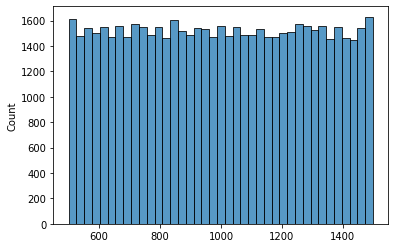

In [31]:
# jobのrewardsの分散
import matplotlib.pylab as plt
import seaborn as sns
N_phase = 4
job_cnts = []
work_cnts = []
print(t_fil)
for Tmax, workers, jobs, dists in data:
    job_cnt = 0
    for job in jobs:
        job_cnts.append(job.Ntask)
sns.histplot(x=job_cnts)

In [7]:
import matplotlib.pylab as plt
import seaborn as sns
N_phase = 4
job_cnts = []
work_cnts = []
print(t_fil)
dist_all = []
for Tmax, workers, jobs, dists in data:
    for dist in dists:
        dist_all += dist
print(max(dist_all))
# sns.histplot(dist_all)

1000
365


In [8]:
len(dist_all)

82481469

: 

In [ ]:
data[0]